# 4.1 Imports

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns

from numpy import mean, std
from collections import Counter
import time

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import SparsePCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from imblearn.over_sampling import ADASYN
from imblearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load train data
train = pd.read_csv('data/train_prep_1.csv')

In [4]:
# load test data
test = pd.read_csv('data/test_prep_1.csv')

In [5]:
train.shape

(32462, 12)

In [6]:
test.shape

(16232, 12)

In [7]:
X_train = train.drop(columns=['target'])
X_train.shape

(32462, 11)

In [8]:
X_test = test.drop(columns=['target'])
X_test.shape

(16232, 11)

In [9]:
y_train = train['target']
y_train.shape

(32462,)

In [10]:
y_test = test['target']
y_test.shape

(16232,)

# 4.2 Logistic Regression

In [11]:
# numerical features
num_features = ['age','education','hours_per_week']

# numerical transformer
num_transformer = StandardScaler()

In [12]:
# categorical features
cat_features = ['workclass','marital_status','occupation','relationship',
               'race','sex','capital_change','native_country']

# categorical transformer
cat_transformer = OneHotEncoder(handle_unknown='ignore')

In [13]:
# preprocessing

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

In [16]:
# whole model pipeline

logistic_regression = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',LogisticRegression(random_state=20210510, n_jobs=-1))
])

In [17]:
# model fitting

start_time = time.time()

logistic_regression.fit(X_train, y_train)

end_time = time.time()

time1 = end_time - start_time
print(f'model training time: %.3fs' % time1)

model training time: 5.057s


In [18]:
# model evaluations can be put in the end
# for different models comparison
# create functions for repeatations

In [19]:
# model evaluation

def print_score(model):
    print('model score: %.3f' % model.score(X_test,y_test))
    print('\n')

In [20]:
# model evaluation
print_score(logistic_regression)

model score: 0.843




In [21]:
# k-fold cross validation

# cross validation
cv = KFold(n_splits=10, random_state=20210517, shuffle=True)

# evaluate model
scores = cross_val_score(logistic_regression, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)

print('K-fold cross validation accracy score: %.3f (%.3f)' % (mean(scores), std(scores)))

K-fold cross validation accracy score: 0.843 (0.010)


In [22]:
# classification reports

def print_classfication_reports(model):
    y_test_pred = model.predict(X_test)

    print('Classification report on test data:')
    print(classification_report(y_test, y_test_pred))

    y_train_pred = model.predict(X_train)

    print('Classification report on train data:')
    print(classification_report(y_train, y_train_pred))

In [23]:
# classification reports
print_classfication_reports(logistic_regression)

Classification report on test data:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12397
           1       0.71      0.57      0.63      3835

    accuracy                           0.84     16232
   macro avg       0.79      0.75      0.77     16232
weighted avg       0.84      0.84      0.84     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     24635
           1       0.71      0.58      0.64      7827

    accuracy                           0.84     32462
   macro avg       0.79      0.75      0.77     32462
weighted avg       0.84      0.84      0.84     32462



Logistic regression: ROC AUD = 0.894


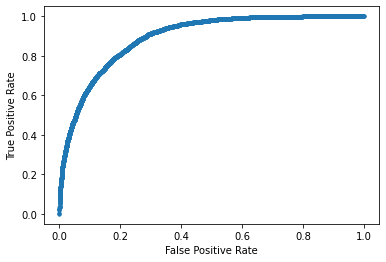

In [24]:
# area under curve (AUC) of receiver operating charisteristic (ROC) curve

# predict probabilities
model_probs = logistic_regression.predict_proba(X_test)

# keep probabilities for the positive outcome only
model_probs = model_probs[:, 1]

# calculate scores
model_auc = roc_auc_score(y_test, model_probs)

# summarize scores
print('Logistic regression: ROC AUD = %.3f' % (model_auc))

# calculate roc curves
# fpr, tpr: false positive rate, true positive rate
fpr, tpr, _ = roc_curve(y_test, model_probs)

# plot roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.legend()
plt.show()

In [26]:
# grid search

param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.1, 1.0, 10, 100]
}

grid_search = GridSearchCV(logistic_regression, param_grid, scoring='precision', verbose=1, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best params:
{'classifier__C': 0.1, 'classifier__penalty': 'l2'}


# 4.3 Logistic Regression with ADASYN

In [33]:
# preprocessing stay the same
# only edit the whole model pipeline

In [34]:
# oversampler
adasyn = ADASYN(random_state=20210517,n_jobs=-1)

In [35]:
# as 'pipeline' in sklearn library does not support 'adasyn'
# 'adasyn' function has no .fit_transform
# have to use 'make_pipeline' in imblearn library

logistic_adasyn = make_pipeline(preprocessor, adasyn ,LogisticRegression(random_state=20210510, n_jobs=-1))

In [40]:
logistic_adasyn

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'education',
                                                   'hours_per_week']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['workclass',
                                                   'marital_status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'capital_change',
                                                   'native_country'])])),
                ('adasyn', ADASYN(n_jobs=-1, random_state=20210517)),
                ('logisticregression',
                 LogisticRegression(n_jobs=-1, random_state=202105

In [36]:
# model fitting

start_time = time.time()

logistic_adasyn.fit(X_train, y_train)

end_time = time.time()

time2 = end_time - start_time
print(f'model training time: %.3fs' % time2)

model training time: 37.130s


In [38]:
# model evaluation
print_score(logistic_adasyn)

# classification reports
print_classfication_reports(logistic_adasyn)

model score: 0.771


Classification report on test data:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83     12397
           1       0.51      0.87      0.64      3835

    accuracy                           0.77     16232
   macro avg       0.73      0.81      0.74     16232
weighted avg       0.85      0.77      0.79     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.95      0.74      0.83     24635
           1       0.52      0.88      0.65      7827

    accuracy                           0.77     32462
   macro avg       0.74      0.81      0.74     32462
weighted avg       0.85      0.77      0.79     32462



In [41]:
# grid search

param_grid = {
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__C': [0.1, 1.0, 10, 100]
}

grid_search = GridSearchCV(logistic_adasyn, param_grid, scoring='precision', verbose=1, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

# 4.4 Linear Support Vector Classification (SVC)

In [42]:
# preprocessing stay the same
# only edit the whole model pipeline

In [43]:
# whole model pipeline

linear_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',LinearSVC(random_state=20210518))
])

In [44]:
# model fitting

start_time = time.time()

linear_svc.fit(X_train, y_train)

end_time = time.time()

time3 = end_time - start_time
print(f'model training time: %.3fs' % time3)

model training time: 5.805s


In [45]:
# model evaluation
print_score(linear_svc)

# classification reports
print_classfication_reports(linear_svc)

model score: 0.844


Classification report on test data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12397
           1       0.71      0.57      0.63      3835

    accuracy                           0.84     16232
   macro avg       0.79      0.75      0.77     16232
weighted avg       0.84      0.84      0.84     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     24635
           1       0.72      0.57      0.64      7827

    accuracy                           0.84     32462
   macro avg       0.80      0.75      0.77     32462
weighted avg       0.84      0.84      0.84     32462



In [46]:
# grid search

param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__loss': ['hinge','squared_hinge'],
    'classifier__C': [0.1, 1.0, 10, 100]
}

grid_search = GridSearchCV(linear_svc, param_grid, scoring='precision', verbose=1, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params:
{'classifier__C': 10, 'classifier__loss': 'squared_hinge', 'classifier__penalty': 'l2'}


In [47]:
# whole model pipeline with best params

linear_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',LinearSVC(C=10, random_state=20210518))
])

# model fitting

start_time = time.time()

linear_svc.fit(X_train, y_train)

end_time = time.time()

time3 = end_time - start_time
print(f'model training time: %.3fs' % time3)

# model evaluation
print_score(linear_svc)

# classification reports
print_classfication_reports(linear_svc)

model training time: 4.914s
model score: 0.844


Classification report on test data:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     12397
           1       0.71      0.58      0.64      3835

    accuracy                           0.84     16232
   macro avg       0.79      0.75      0.77     16232
weighted avg       0.84      0.84      0.84     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     24635
           1       0.71      0.58      0.64      7827

    accuracy                           0.84     32462
   macro avg       0.79      0.75      0.77     32462
weighted avg       0.84      0.84      0.84     32462



# 4.5 K Nearest Neighbors Classification

In [35]:
# preprocessing stay the same
# only edit the whole model pipeline

In [36]:
# whole model pipeline

kneighbors = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',KNeighborsClassifier())
])

In [37]:
# model fitting

start_time = time.time()

kneighbors.fit(X_train, y_train)

end_time = time.time()

time4 = end_time - start_time
print(f'model training time: %.3fs' % time4)

model training time: 0.115s


In [38]:
# model evaluation
print_score(kneighbors)

# classification reports
print_classfication_reports(kneighbors)

model score: 0.825


Classification report on test data:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     12397
           1       0.64      0.58      0.61      3835

    accuracy                           0.82     16232
   macro avg       0.76      0.74      0.75     16232
weighted avg       0.82      0.82      0.82     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     24635
           1       0.77      0.69      0.73      7827

    accuracy                           0.88     32462
   macro avg       0.84      0.81      0.82     32462
weighted avg       0.87      0.88      0.87     32462



In [42]:
# grid search 1

param_grid = {
    'classifier__n_neighbors': [5, 10, 25, 50, 100]
}

grid_search = GridSearchCV(kneighbors, param_grid, verbose=1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best params:
{'classifier__n_neighbors': 50}


In [45]:
# grid search 2

param_grid = {
    'classifier__n_neighbors': [30, 40, 50, 60, 70, 80, 90]
}

grid_search = GridSearchCV(kneighbors, param_grid, verbose=1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best params:
{'classifier__n_neighbors': 40}


In [46]:
# whole model pipeline with best params

kneighbors = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',KNeighborsClassifier(n_neighbors=40))
])

# model fitting

start_time = time.time()

kneighbors.fit(X_train, y_train)

end_time = time.time()

time4 = end_time - start_time
print(f'model training time: %.3fs' % time4)

# model evaluation
print_score(kneighbors)

# classification reports
print_classfication_reports(kneighbors)

model training time: 0.159s
model score: 0.843


Classification report on test data:
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     12397
           1       0.71      0.57      0.63      3835

    accuracy                           0.84     16232
   macro avg       0.79      0.75      0.77     16232
weighted avg       0.84      0.84      0.84     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     24635
           1       0.73      0.60      0.66      7827

    accuracy                           0.85     32462
   macro avg       0.81      0.77      0.78     32462
weighted avg       0.84      0.85      0.85     32462



# 4.6 Decision Tree Classification

In [27]:
# preprocessing stay the same
# only edit the whole model pipeline

In [28]:
# whole model pipeline

decision_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=20210521, class_weight='balanced'))
])

In [29]:
# model fitting

start_time = time.time()

decision_tree.fit(X_train, y_train)

end_time = time.time()

time5 = end_time - start_time
print(f'model training time: %.3fs' % time5)

model training time: 1.795s


In [30]:
# model evaluation
print_score(decision_tree)

# classification reports
print_classfication_reports(decision_tree)

model score: 0.783


Classification report on test data:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     12397
           1       0.54      0.60      0.57      3835

    accuracy                           0.78     16232
   macro avg       0.70      0.72      0.71     16232
weighted avg       0.79      0.78      0.79     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     24635
           1       0.86      0.99      0.92      7827

    accuracy                           0.96     32462
   macro avg       0.93      0.97      0.95     32462
weighted avg       0.96      0.96      0.96     32462



In [32]:
# grid search 1

depth = [
    1, 2, 3, 4, 5,
    6, 7, 8, 9, 10,
    12, 14, 16, 18, 20
]

num_leaf = [
    1, 2, 3, 4, 5,
    6, 7, 8, 9, 10,
    12, 14, 16, 18, 20
]

param_grid = {
        'classifier__max_depth': depth,
        'classifier__min_samples_leaf': num_leaf
}

grid_search = GridSearchCV(decision_tree, param_grid, verbose=1, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
Best params:
{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1}


In [31]:
# grid search 2

depth = [
    20, 30, 40, 50, 60,
    70, 80, 90, 100, 200
]

param_grid = {
        'classifier__max_depth': depth
}

grid_search = GridSearchCV(decision_tree, param_grid, scoring='precision', verbose=1, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:")
print(grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params:
{'classifier__max_depth': 60}


In [32]:
# whole model pipeline with best params

decision_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',DecisionTreeClassifier(max_depth=60, random_state=20210521, class_weight='balanced'))
])

# model fitting

start_time = time.time()

decision_tree.fit(X_train, y_train)

end_time = time.time()

time5 = end_time - start_time
print(f'model training time: %.3fs' % time5)

# model evaluation
print_score(decision_tree)

# classification reports
print_classfication_reports(decision_tree)

model training time: 1.851s
model score: 0.783


Classification report on test data:
              precision    recall  f1-score   support

           0       0.87      0.84      0.85     12397
           1       0.54      0.60      0.57      3835

    accuracy                           0.78     16232
   macro avg       0.70      0.72      0.71     16232
weighted avg       0.79      0.78      0.79     16232

Classification report on train data:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     24635
           1       0.86      0.99      0.92      7827

    accuracy                           0.96     32462
   macro avg       0.93      0.97      0.95     32462
weighted avg       0.96      0.96      0.96     32462



In [ ]:
# grid search try scoring focus on precision
# check regression parameters
## drop col with low coefficient

In [ ]:
#END